In [1]:
import os
os.chdir('/Users/yongjunchoi/Documents/GitHub/Research/Research')

In [2]:
from Bio import Phylo
import random
from collections import Counter
from Bio.Phylo.Newick import Clade
import copy

true_tree_path = "Polytomy/Codes/nwk/Polytomy_Test/tree_pruned.nwk"
true_tree = Phylo.read(true_tree_path, "newick")

In [3]:
def find_nodes_with_m_leaves(clade, m):
    nodes = []
    def helper(node):
        if node.is_terminal():
            return 1
        leaf_count = sum(helper(c) for c in node.clades)
        if leaf_count == m:
            nodes.append(node)
        return leaf_count
    helper(clade)
    return nodes

In [4]:
polytomy_size = 25
tree_sample_size = 100

In [5]:
copy_tree = copy.deepcopy(true_tree)
nodes_with_m_leaves = find_nodes_with_m_leaves(copy_tree.root, polytomy_size)

print("Before polytomizing: Total daughters: ", len(copy_tree.get_terminals()))
print(*[f"{k} daughters: {v} nodes" 
    for k, v in sorted(Counter(len(c.clades) for c in copy_tree.find_clades()).items())], 
    sep=", ")

if len(nodes_with_m_leaves) == 0:
    print("\nUnable to polytomize!")
else:
    print("\nPolytomizing one of the subtree among {} trees...\n".format(len(nodes_with_m_leaves)))

    def count_children(node):
        counts = Counter()
        child_count = len(node.clades)
        counts[child_count] += 1
        
        for child in node.clades:
            counts.update(count_children(child))
        return counts

    child_counter = count_children(copy_tree.root)

    picked_node = random.choice(nodes_with_m_leaves)

    answer_subtree = copy.deepcopy(picked_node)
    # 리프 노드 이름 t1, t2, ...
    for i, leaf in enumerate(answer_subtree.get_terminals(), start=1):
        leaf.name = f"t{i}"

    # 내부 노드 이름 제거
    for n in answer_subtree.get_nonterminals():
        n.name = None

    # 모든 branch_length 제거 (재귀)
    def remove_branch_length(clade):
        clade.branch_length = None
        for child in clade.clades:
            remove_branch_length(child)

    remove_branch_length(answer_subtree)
    Phylo.write(answer_subtree, "Polytomy/Codes/nwk/TEST/Answer/polytomy_answer_tree.nwk", "newick")

    # Newick 문자열로 가져오기
    from io import StringIO
    output = StringIO()
    Phylo.write(answer_subtree, output, "newick")
    newick_str = output.getvalue()

    # :0.00000 제거
    import re
    newick_str_no_branch = re.sub(r":0\.0+","", newick_str)

    # 파일로 저장
    with open("Polytomy/Codes/nwk/TEST/Answer/polytomy_answer_tree.nwk","w") as f:
        f.write(newick_str_no_branch)

    def polytomize_node(node):
        leaves = node.get_terminals()
        node.clades = leaves

    polytomize_node(picked_node)
    print("After polytomizing: Total daughters: ", len(copy_tree.get_terminals()))
    print(*[f"{k} daughters: {v} nodes" 
        for k, v in sorted(Counter(len(c.clades) for c in copy_tree.find_clades()).items())], 
      sep=", ")

Before polytomizing: Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 164 nodes, 2 daughters: 983 nodes

Polytomizing one of the subtree among 6 trees...

After polytomizing: Total daughters:  984
0 daughters: 984 nodes, 1 daughters: 159 nodes, 2 daughters: 959 nodes, 25 daughters: 1 nodes


In [6]:
# Tree to Canonical Tree Form
## Load rpy2: R to Python
%load_ext rpy2.ipython

import rpy2.robjects as ro
print(ro.r('version'))

Error importing in API mode: ImportError("dlopen(/Users/yongjunchoi/Library/Python/3.9/lib/python/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <08761B8B-0767-3CA6-9437-5468D1CD700F> /Users/yongjunchoi/Library/Python/3.9/lib/python/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


               _                           
platform       aarch64-apple-darwin20      
arch           aarch64                     
os             darwin20                    
system         aarch64, darwin20           
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             



In [7]:
%%R -i polytomy_size -i tree_sample_size
library(ape)
library(poweRbal)

leaves <- polytomy_size
reps   <- tree_sample_size
path <- "Polytomy/Codes/nwk/TEST/Samples"
if (!dir.exists(path)) dir.create(path, recursive = TRUE)

# 모델과 파라미터를 리스트로 정의
models <- list(
  list(name="BD", type="BD", params=data.frame(birth=c(1,2), death=c(0,0.5))),
  list(name="BT", type="Beta", params=data.frame(beta=c(0.2,0.5))),
  list(name="KC", type="KC", params=NULL),
  list(name="YL", type="Yule", params=NULL),
  list(name="UF", type="Uniform", params=NULL)
)

for (m in models) {
  model <- m$name
  type  <- m$type
  params <- m$params
  
  if (type=="BD") {
    for (i in 1:nrow(params)) {
      b <- params$birth[i]
      d <- params$death[i]
      trees <- lapply(1:reps, function(j) genAltBirthDeathTree(n=leaves, BIRTHRATE=b, DEATHRATE=d, TRIES=1000))
      file_name <- sprintf("%s_b%.1f_d%.1f_l%d_r%d.nwk", model, b, d, leaves, reps)
      write.tree(trees, file=file.path(path, file_name))
      cat("Saved:", file_name, "\n")
    }
  } else if (type=="Beta") {
    for (i in 1:nrow(params)) {
      b <- params$beta[i]
      trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=b))
      file_name <- sprintf("%s_b%.1f_l%d_r%d.nwk", model, b, leaves, reps)
      write.tree(trees, file=file.path(path, file_name))
      cat("Saved:", file_name, "\n")
    }
  } else if (type=="KC") {
    trees <- lapply(1:reps, function(j) {
      tr <- rcoal(n=leaves)
      tr$edge.length <- NULL
      tr
    })
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
    
  } else if (type=="Yule") {
    trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=0))
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
    
  } else if (type=="Uniform") {
    trees <- lapply(1:reps, function(j) genAldousBetaTree(n=leaves, BETA=-1.5))
    file_name <- sprintf("%s_l%d_r%d.nwk", model, leaves, reps)
    write.tree(trees, file=file.path(path, file_name))
    cat("Saved:", file_name, "\n")
  }
}

Saved: BD_b1.0_d0.0_l25_r100.nwk 
Saved: BD_b2.0_d0.5_l25_r100.nwk 
Saved: BT_b0.2_l25_r100.nwk 
Saved: BT_b0.5_l25_r100.nwk 
Saved: KC_l25_r100.nwk 
Saved: YL_l25_r100.nwk 
Saved: UF_l25_r100.nwk 


In [8]:
import os
from glob import glob

tree_folder = "Polytomy/Codes/nwk/TEST/Samples"
prefixes = ["BD", "BT", "KC", "YL", "UF"]

# 모델별로 파일 리스트 만들기
all_files = sorted(glob(os.path.join(tree_folder, "*.nwk")))

# 각 모델별로 그룹화
model_files = []
for p in prefixes:
    files = sorted([f for f in all_files 
                    if os.path.basename(f).startswith(p) 
                    and f"l{polytomy_size}" in os.path.basename(f)])
    model_files.extend(files)  # 순서대로 하나의 리스트에 추가

# model_1, model_2, ... 변수 생성
for i, fpath in enumerate(model_files, start=1):
    globals()[f"model_{i}"] = fpath

# models 리스트에 담기
models = [globals()[f"model_{i}"] for i in range(1, len(model_files)+1)]

# 확인
for i, f in enumerate(models, start=1):
    print(f"model_{i}: {f}")

model_1: Polytomy/Codes/nwk/TEST/Samples/BD_b1.0_d0.0_l25_r100.nwk
model_2: Polytomy/Codes/nwk/TEST/Samples/BD_b2.0_d0.5_l25_r100.nwk
model_3: Polytomy/Codes/nwk/TEST/Samples/BT_b0.2_l25_r100.nwk
model_4: Polytomy/Codes/nwk/TEST/Samples/BT_b0.5_l25_r100.nwk
model_5: Polytomy/Codes/nwk/TEST/Samples/KC_l25_r100.nwk
model_6: Polytomy/Codes/nwk/TEST/Samples/YL_l25_r100.nwk
model_7: Polytomy/Codes/nwk/TEST/Samples/UF_l25_r100.nwk


In [9]:
import dendropy

def colless_index(tree):
    """
    Computes Colless index: sum of absolute differences in leaf counts
    for all internal nodes.
    """
    def count_leaves(node):
        if node.is_leaf():
            return 1
        return sum(count_leaves(c) for c in node.child_nodes())

    def colless_node(node):
        if node.is_leaf() or len(node.child_nodes()) < 2:
            return 0
        left, right = node.child_nodes()[:2]  # binary assumption
        nl = count_leaves(left)
        nr = count_leaves(right)
        return abs(nl - nr) + colless_node(left) + colless_node(right)

    return colless_node(tree.seed_node)

import dendropy

def sackins_index(tree):
    """
    Computes Sackin index: sum of depths of all leaf nodes
    """
    def leaf_depth_sum(node, depth=0):
        if node.is_leaf():
            return depth
        return sum(leaf_depth_sum(c, depth+1) for c in node.child_nodes())

    return leaf_depth_sum(tree.seed_node)

def tree_height(tree):
    max_depth = 0
    def dfs(nd, depth):
        nonlocal max_depth
        if nd.is_leaf():
            max_depth = max(max_depth, depth)
        for c in nd.child_nodes():
            dfs(c, depth+1)
    dfs(tree.seed_node, 0)
    return max_depth

import math

def root_split_ratio_x(tree):
    root_children = tree.seed_node.child_nodes()
    if len(root_children) >= 2:
        n_left = len(root_children[0].leaf_nodes())
        n_right = len(root_children[1].leaf_nodes())
    elif len(root_children) == 1:
        n_left = len(root_children[0].leaf_nodes())
        n_right = 0
    else:
        n_left = 0
        n_right = 0

    # 왼쪽을 항상 작은 쪽으로
    if n_left > n_right:
        n_left, n_right = n_right, n_left

    return n_left  # x 값만 반환

In [10]:
import dendropy
import pandas as pd

# 모델별 파일 리스트
# models = [model_1, model_2, ...] 이미 존재한다고 가정
model_labels = [f"model_{i}" for i in range(1, len(models)+1)]

# 데이터프레임 초기화
df_stats = pd.DataFrame(columns=["Model", "Colless", "Sackin", "Height", "RootSplit"])

for label, fpath in zip(model_labels, models):
    # 파일 하나에 여러 트리가 있으면 TreeList로 읽기
    trees = dendropy.TreeList.get(path=fpath, schema="newick", preserve_underscores=True)
    for tree in trees:
        df_stats.loc[len(df_stats)] = {
            "Model": label,
            "Colless": colless_index(tree),
            "Sackin": sackins_index(tree),
            "Height": tree_height(tree),
            "RootSplit": root_split_ratio_x(tree)
        }

# polytomy_answer_tree.nwk 통계 계산
answer_tree_path = "Polytomy/Codes/nwk/TEST/Answer/polytomy_answer_tree.nwk"
answer_tree = dendropy.Tree.get(path=answer_tree_path, schema="newick", preserve_underscores=True)

answer_stats = {
    "Colless": colless_index(answer_tree),
    "Sackin": sackins_index(answer_tree),
    "Height": tree_height(answer_tree),
    "RootSplit": root_split_ratio_x(answer_tree)
}

# df_stats 확인
print(df_stats.head())

     Model  Colless  Sackin  Height  RootSplit
0  model_1       82     162       9          1
1  model_1       26     124       6          9
2  model_1       74     158       9          1
3  model_1       45     135       8          7
4  model_1       48     134       8          6


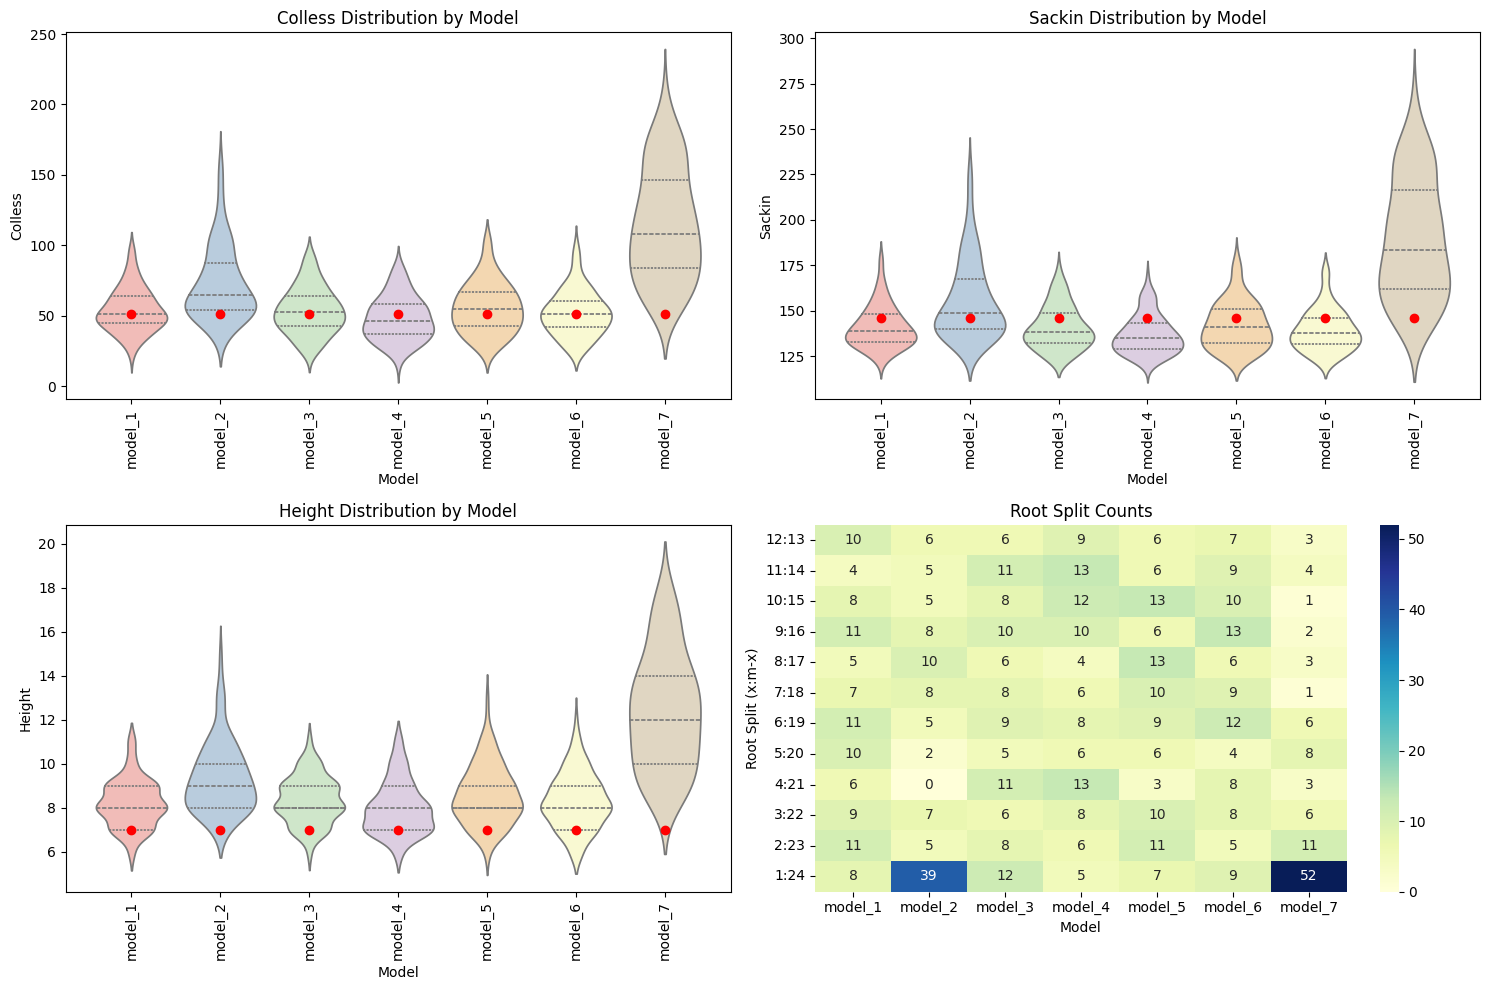

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 그릴 메트릭 설정
# -----------------------------
metrics = ["Colless", "Sackin", "Height"]
model_labels = df_stats['Model'].unique()

# -----------------------------
# 2. 2x2 Figure 설정
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# -----------------------------
# 3. Violin plots for Colless, Sackin, Height
# -----------------------------
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.violinplot(
        x="Model",
        y=metric,
        data=df_stats,
        inner="quartile",
        order=model_labels,
        palette="Pastel1",
        ax=ax
    )
    # 정답 트리 표시
    ax.scatter(
        x=range(len(model_labels)),
        y=[answer_stats[metric]]*len(model_labels),
        color='red',
        zorder=10,
        label="Answer Tree"
    )
    ax.set_title(f"{metric} Distribution by Model")
    ax.set_xticks(range(len(model_labels)))
    ax.set_xticklabels(model_labels, rotation=90)

# -----------------------------
# 4. Heatmap for Root Split
# -----------------------------
m = polytomy_size  # 전체 leaf 수

# pivot table: 행=RootSplit, 열=Model
heat_data = df_stats.pivot_table(
    index='RootSplit',
    columns='Model',
    aggfunc='size',
    fill_value=0
)

# y축 정렬 (1이 가장 아래)
heat_data = heat_data.sort_index(ascending=False)

ax = axes[1,1]
sns.heatmap(
    heat_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    ax=ax
)

# y축 tick을 x:(m-x) 형태로 변환
y_labels = [f"{x}:{m-x}" for x in heat_data.index]
ax.set_yticklabels(y_labels, rotation=0)

ax.set_title("Root Split Counts")
ax.set_xlabel("Model")
ax.set_ylabel("Root Split (x:m-x)")

plt.tight_layout()
plt.show()

In [12]:
from dendropy import Tree, TreeList, TaxonNamespace
from dendropy.calculate import treecompare
import matplotlib.pyplot as plt

# -----------------------------
# 1. 정답 트리 로드
# -----------------------------
answer_tree_path = "Polytomy/Codes/nwk/TEST/Answer/polytomy_answer_tree.nwk"

# 공통 TaxonNamespace
taxa = TaxonNamespace()

# 정답 트리 로드
answer_tree = Tree.get(path=answer_tree_path, schema="newick", taxon_namespace=taxa, preserve_underscores=True)
for e in answer_tree.postorder_edge_iter():
    e.length = None  # edge lengths 제거

# -----------------------------
# 2. 모델별 트리 RF 거리 계산
# -----------------------------
rf_distances = []
nrf_distances = []

for model_files in models:  # models 리스트, 각 요소는 파일 경로 리스트
    if isinstance(model_files, str):
        model_files = [model_files]
    
    dists = []
    n_dists = []
    for f in model_files:
        # 파일 내 모든 트리 읽기
        trees = TreeList.get(path=f, schema="newick", taxon_namespace=taxa, preserve_underscores=True)
        for t in trees:
            # edge lengths 제거
            for e in t.postorder_edge_iter():
                e.length = None
            # RF 거리 계산
            rf = treecompare.symmetric_difference(answer_tree, t)
            n_leaves = len(t.leaf_nodes())
            rf_norm = rf / (2 * (n_leaves - 3))

            dists.append(rf)
            n_dists.append(rf_norm)
    rf_distances.append(dists)
    nrf_distances.append(n_dists)

In [13]:
%%R -i answer_tree_path -i models -o qds -o nqds

library(ape)
library(Quartet)

# 정답 트리 읽기
answer_tree <- read.tree(answer_tree_path)

qds <- list()   # 각 파일별 Quartet Distance
nqds <- list()  # 정규화된 QD

for (i in seq_along(models)) {
  file_path <- models[[i]]  # 파일 경로
  tree_lines <- readLines(file_path)  # 파일 내 모든 트리 (한 줄에 하나)
  
  qd_vec <- numeric(length(tree_lines))
  nqd_vec <- numeric(length(tree_lines))
  
  for (j in seq_along(tree_lines)) {
    tr_text <- tree_lines[j]
    
    # Newick 문자열을 객체로 읽기
    tr <- read.tree(text = tr_text)
    num_leaves <- length(tr$tip.label)
    
    # Quartet distance 계산
    # 파일 경로 대신 임시 파일 필요
    tmp_file <- tempfile(fileext = ".nwk")
    writeLines(tr_text, tmp_file)
    qd_val <- QuartetDistance(answer_tree_path, tmp_file)
    unlink(tmp_file)
    
    qd_vec[j] <- qd_val
    nqd_vec[j] <- qd_val / choose(num_leaves, 4)
  }
  
  qds[[i]] <- qd_vec
  nqds[[i]] <- nqd_vec
}
print(length(qds[[1]]))
print(length(nqds[[1]]))

[1] 100
[1] 100


필요한 패키지를 로딩중입니다: TreeTools


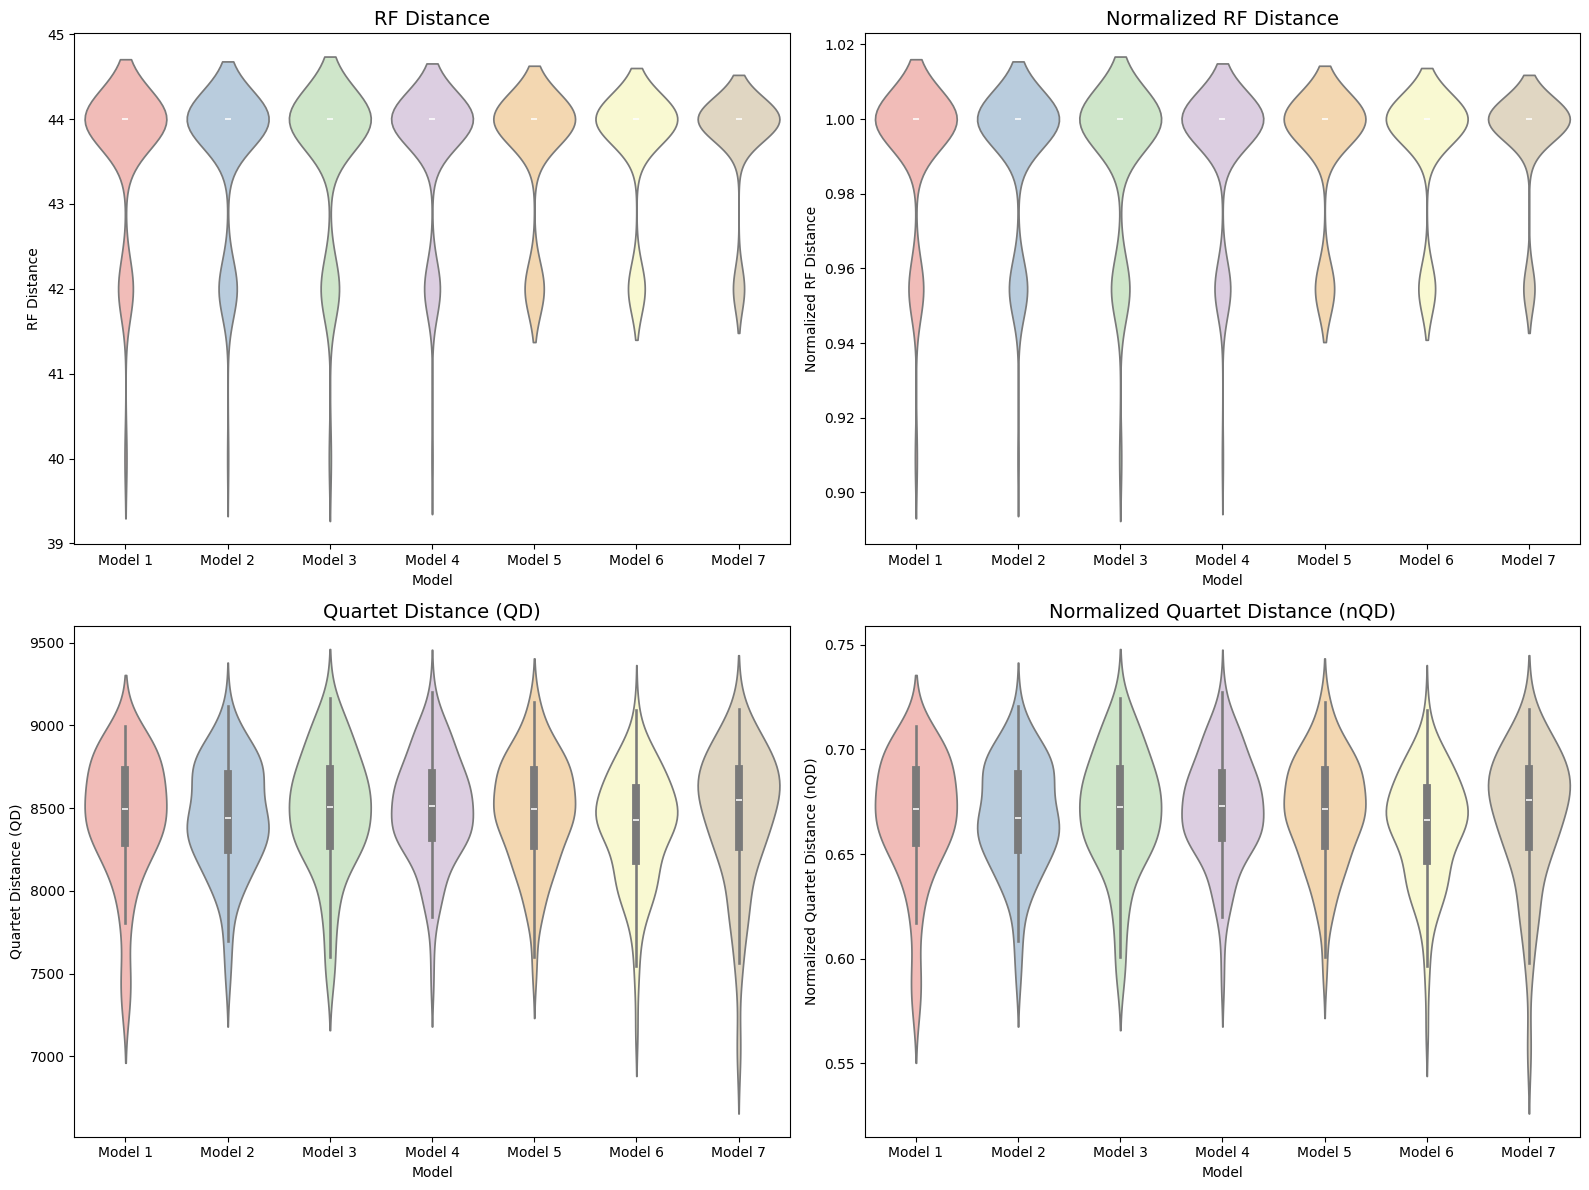

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

# 경고 숨기기
warnings.filterwarnings("ignore")

# subplot 설정
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # 1차원 배열로

# 그릴 데이터와 이름
data_metrics = [
    (rf_distances, "RF Distance"),
    (nrf_distances, "Normalized RF Distance"),
    (qds, "Quartet Distance (QD)"),
    (nqds, "Normalized Quartet Distance (nQD)")
]

for ax, (data_list, metric_name) in zip(axes, data_metrics):
    # 모델 이름
    model_labels = [f"Model {i+1}" for i in range(len(data_list))]
    
    # long-form 데이터프레임 생성
    df = pd.DataFrame({
        "Value": [v for model in data_list for v in model],
        "Model": [model_labels[i] for i, model in enumerate(data_list) for _ in model]
    })
    
    sns.violinplot(x="Model", y="Value", data=df, inner="box", palette="Pastel1", ax=ax)
    ax.set_title(metric_name, fontsize=14)
    ax.set_xlabel("Model")
    ax.set_ylabel(metric_name)

plt.tight_layout()
plt.show()

In [15]:
def resolve_polytomy(clade):
    """Polytomy를 binary로 변환"""
    if clade.is_terminal():
        return
    
    while len(clade.clades) > 2:
        # 두 개 자식만 남기고 나머지는 새로운 내부 노드로 묶기
        first = clade.clades.pop(0)
        second = clade.clades.pop(0)
        new_internal = Clade()
        new_internal.clades = [first, second]
        clade.clades.insert(0, new_internal)
    
    # 재귀 적용
    for child in clade.clades:
        resolve_polytomy(child)

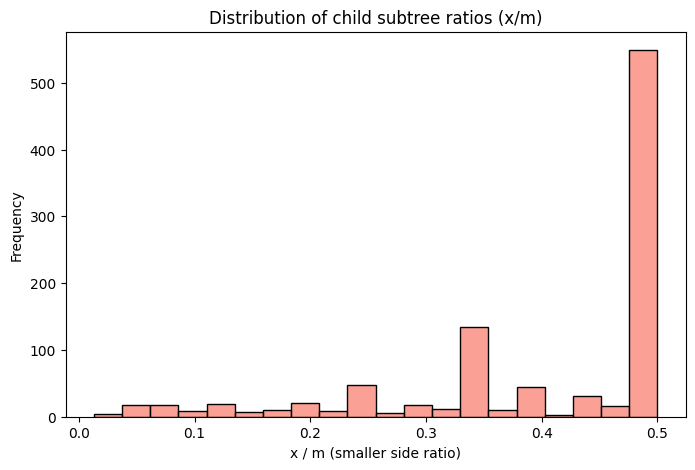

In [16]:
from Bio import Phylo
import matplotlib.pyplot as plt
import seaborn as sns

# 트리 불러오기 (예시: Newick 파일)
del_polytomy_tree = copy.deepcopy(copy_tree)
resolve_polytomy(del_polytomy_tree.root)

ratios = []

def count_leaves(clade):
    """재귀적으로 leaf 개수 세기"""
    if clade.is_terminal():
        return 1
    return sum(count_leaves(child) for child in clade.clades)

# 내부 노드 순회
# 내부 노드 순회
for clade in del_polytomy_tree.root.find_clades(order="postorder"):
    if not clade.is_terminal() and len(clade.clades) == 2:  # binary node만
        left, right = clade.clades
        left_leaves = count_leaves(left)
        right_leaves = count_leaves(right)
        m = left_leaves + right_leaves
        x = min(left_leaves, right_leaves)
        ratio = x / m
        ratios.append(ratio)

# -----------------------------
# 분포 시각화
# -----------------------------
plt.figure(figsize=(8, 5))
sns.histplot(ratios, bins=20, color="salmon", edgecolor="black")
plt.title("Distribution of child subtree ratios (x/m)")
plt.xlabel("x / m (smaller side ratio)")
plt.ylabel("Frequency")
plt.show()

Text(0.5, 1.0, 'Weighted Distribution of Child Subtree Ratios (x/m)')

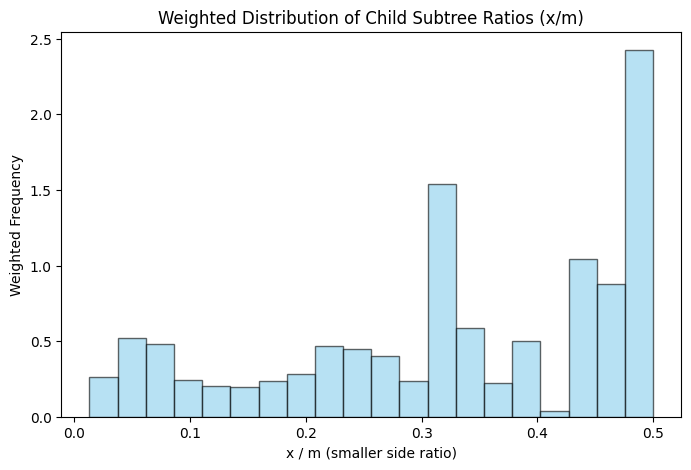

In [17]:
from Bio import Phylo
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# -----------------------------
# 트리 불러오기
# -----------------------------
tree = copy.deepcopy(copy_tree)  # 예시 트리, Newick 불러온 후
resolve_polytomy(tree.root)      # polytomy 제거

# -----------------------------
# 1. Bottom-up leaf count 계산
# -----------------------------
def compute_leaf_counts(node):
    """각 노드에 leaf 개수 저장 (bottom-up)"""
    if node.is_terminal():
        node.num_leaves = 1
    else:
        node.num_leaves = sum(compute_leaf_counts(child) for child in node.clades)
    return node.num_leaves

compute_leaf_counts(tree.root)

# -----------------------------
# 2. Top-down weighted ratio 계산
# -----------------------------
ratios = []
weights = []

def collect_ratios(node, parent_weight=1.0):
    """top-down으로 weight 전달하며 ratio 수집"""
    if node.is_terminal() or len(node.clades) != 2:
        return

    left, right = node.clades
    left_leaves = left.num_leaves
    right_leaves = right.num_leaves
    m = left_leaves + right_leaves
    x = min(left_leaves, right_leaves)
    ratio = x / m

    # 현재 노드의 weight
    left_weight = parent_weight * (left_leaves / m)
    right_weight = parent_weight * (right_leaves / m)

    # ratio와 weight 저장
    ratios.append(ratio)
    weights.append(parent_weight)  # frequency 계산 시 곱할 weight

    # 재귀 호출
    collect_ratios(left, left_weight)
    collect_ratios(right, right_weight)

collect_ratios(tree.root)

import numpy as np
from scipy.stats import gaussian_kde

# 리스트 → numpy 배열
ratios_arr = np.array(ratios)
weights_arr = np.array(weights)

# -----------------------------
# 1. Weighted histogram
# -----------------------------
plt.figure(figsize=(8,5))
plt.hist(ratios_arr, bins=20, weights=weights_arr, color='skyblue', edgecolor='black', alpha=0.6)
plt.xlabel("x / m (smaller side ratio)")
plt.ylabel("Weighted Frequency")
plt.title("Weighted Distribution of Child Subtree Ratios (x/m)")

In [18]:
import numpy as np

# 이미 계산된 ratios와 weights를 사용한다고 가정
# ratios: list of x/m
# weights: list of top-down weight

ratios_arr = np.array(ratios)
weights_arr = np.array(weights)

# -----------------------------
# 1. Unweighted 샘플링 함수
# -----------------------------
def sample_ratio_unweighted(size=1):
    """
    단순 ratio 분포에서 샘플링 (unweighted)
    size: 샘플 개수
    """
    return np.random.choice(ratios_arr, size=size)

# -----------------------------
# 2. Weighted 샘플링 함수
# -----------------------------
def sample_ratio_weighted(size=1):
    """
    Weighted ratio 분포에서 샘플링
    size: 샘플 개수
    """
    probs = weights_arr / np.sum(weights_arr)  # normalize weight → 확률
    return np.random.choice(ratios_arr, size=size, p=probs)

# -----------------------------
# 테스트
# -----------------------------
print("Unweighted sample:", sample_ratio_unweighted(5))
print("Weighted sample:", sample_ratio_weighted(5))

Unweighted sample: [0.5  0.25 0.5  0.3  0.25]
Weighted sample: [0.22222222 0.04545455 0.44444444 0.23197492 0.23214286]


In [19]:
from Bio.Phylo.Newick import Clade, Tree
import numpy as np

# -----------------------------
# 1. 트리를 재귀적으로 생성하는 함수
# -----------------------------
def build_tree_general(n_leaves, sample_func, leaf_counter):
    """
    n_leaves: 만들 트리의 leaf 수
    sample_func: sample_ratio_unweighted 또는 sample_ratio_weighted
    leaf_counter: 현재 leaf 번호 (리스트 형태로 전달, 재귀에서 값 공유)
    """
    if n_leaves == 1:
        leaf_name = f"t{leaf_counter[0]}"
        leaf_counter[0] += 1
        return Clade(name=leaf_name)

    # ratio 샘플링 (x/m)
    ratio = sample_func(size=1)[0]
    left_leaves = max(1, int(round(n_leaves * ratio)))
    right_leaves = n_leaves - left_leaves

    left_clade = build_tree_general(left_leaves, sample_func, leaf_counter)
    right_clade = build_tree_general(right_leaves, sample_func, leaf_counter)

    return Clade(clades=[left_clade, right_clade])

# -----------------------------
# 2. branch length 없이 Newick 문자열 생성
# -----------------------------
def clade_to_newick(clade):
    if clade.is_terminal():
        return clade.name
    else:
        subtrees = [clade_to_newick(c) for c in clade.clades]
        return f"({','.join(subtrees)})"

def tree_to_newick_no_branchlength(tree):
    return clade_to_newick(tree.root) + ";"

# -----------------------------
# 3. 트리 생성 & 저장 함수
# -----------------------------
def generate_trees(n_trees=100, n_leaves=10, sample_func=None, filename="trees.nwk"):
    trees_list = []
    with open(filename, "w") as f:
        for i in range(n_trees):
            leaf_counter = [1]  # t1부터 시작
            tree = Tree(root=build_tree_general(n_leaves, sample_func, leaf_counter))
            trees_list.append(tree)
            f.write(tree_to_newick_no_branchlength(tree) + "\n")
    print(f"{n_trees} trees saved to {filename}")
    return trees_list

# -----------------------------
# 4. 사용 예시
# -----------------------------
n_trees = tree_sample_size
n_leaves = polytomy_size

# Unweighted version
trees_unweighted = generate_trees(n_trees=n_trees, n_leaves=n_leaves,
                                  sample_func=sample_ratio_unweighted,
                                  filename="Polytomy/Codes/nwk/TEST/Samples/trees_unweighted.nwk")

# Weighted version
trees_weighted = generate_trees(n_trees=n_trees, n_leaves=n_leaves,
                                sample_func=sample_ratio_weighted,
                                filename="Polytomy/Codes/nwk/TEST/Samples/trees_weighted.nwk")

100 trees saved to Polytomy/Codes/nwk/TEST/Samples/trees_unweighted.nwk
100 trees saved to Polytomy/Codes/nwk/TEST/Samples/trees_weighted.nwk


In [20]:
import dendropy
import pandas as pd

# -----------------------------
# 1. 공통 TaxonNamespace
# -----------------------------
taxa = dendropy.TaxonNamespace()

# -----------------------------
# 2. 새로 생성한 Unweighted / Weighted 트리 읽기 (dendropy)
# -----------------------------
trees_unweighted_dendropy = dendropy.TreeList.get(
    path="Polytomy/Codes/nwk/TEST/Samples/trees_unweighted.nwk",
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)

trees_weighted_dendropy = dendropy.TreeList.get(
    path="Polytomy/Codes/nwk/TEST/Samples/trees_weighted.nwk",
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)

# -----------------------------
# 3. 새 트리 통계 계산
# -----------------------------
records_new = []

# Unweighted
for tree in trees_unweighted_dendropy:
    records_new.append({
        "Model": "Unweighted",
        "Colless": colless_index(tree),
        "Sackin": sackins_index(tree),
        "Height": tree_height(tree),
        "RootSplit": root_split_ratio_x(tree)
    })

# Weighted
for tree in trees_weighted_dendropy:
    records_new.append({
        "Model": "Weighted",
        "Colless": colless_index(tree),
        "Sackin": sackins_index(tree),
        "Height": tree_height(tree),
        "RootSplit": root_split_ratio_x(tree)
    })

df_new_stats = pd.DataFrame(records_new)

# -----------------------------
# 4. 기존 모델 + 새 트리 통계 합치기
# -----------------------------
df_combined = pd.concat([df_stats, df_new_stats], ignore_index=True)

# -----------------------------
# 5. 결과 확인
# -----------------------------
print(df_combined.head())

     Model  Colless  Sackin  Height  RootSplit
0  model_1       82     162       9          1
1  model_1       26     124       6          9
2  model_1       74     158       9          1
3  model_1       45     135       8          7
4  model_1       48     134       8          6


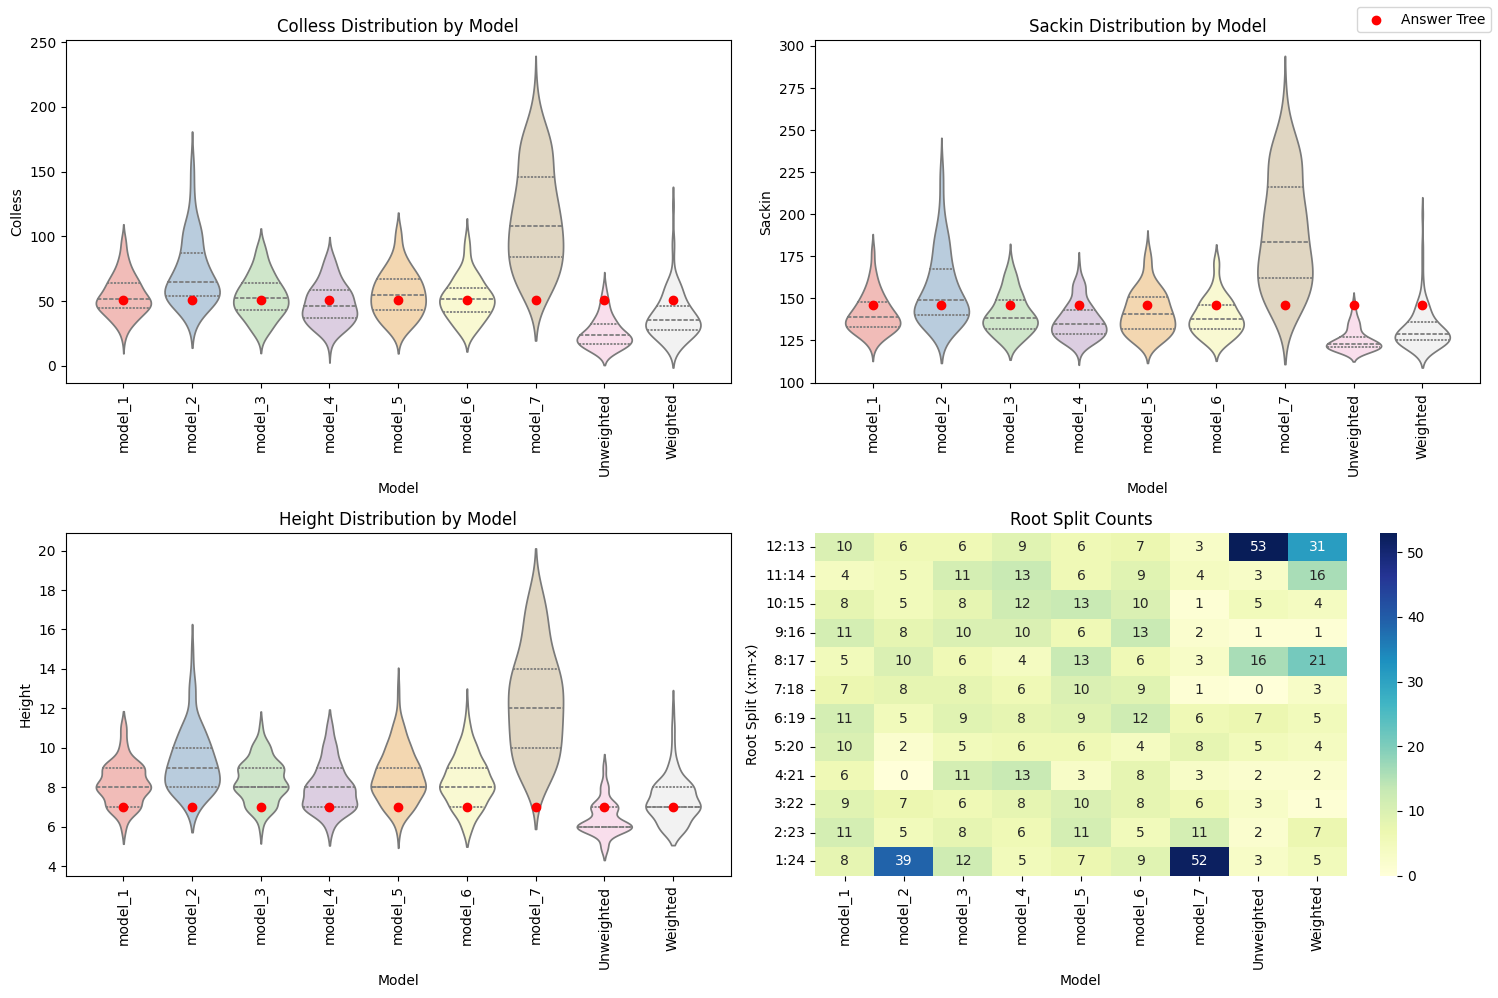

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# 1. 그릴 메트릭 설정
# -----------------------------
metrics = ["Colless", "Sackin", "Height"]
m = polytomy_size  # 전체 leaf 수

# 모델 순서: weighted, unweighted을 마지막으로
model_order_raw = list(df_combined['Model'].unique())
special = ["Unweighted", "Weighted"]
model_order = [m for m in model_order_raw if m not in special] + special

# -----------------------------
# 2. Figure 설정 (2x2)
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# -----------------------------
# 3. Violin plots
# -----------------------------
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.violinplot(
        x="Model",
        y=metric,
        data=df_combined,
        inner="quartile",
        palette="Pastel1",
        order=model_order,
        ax=ax
    )
    # 정답 트리 값 표시
    ax.scatter(
        x=range(len(model_order)),
        y=[answer_stats[metric]]*len(model_order),
        color='red',
        zorder=10,
        label="Answer Tree" if i == 0 else None
    )
    ax.set_title(f"{metric} Distribution by Model")
    ax.set_xticklabels(model_order, rotation=90)

# -----------------------------
# 4. Heatmap for Root Split
# -----------------------------
df_combined['X'] = df_combined['RootSplit'].astype(int)

# pivot table: 행=X, 열=Model (모델 순서 반영)
heat_data = df_combined.pivot_table(
    index='X',
    columns='Model',
    aggfunc='size',
    fill_value=0
).reindex(columns=model_order)

# y축을 뒤집기 (1이 아래쪽)
heat_data = heat_data.sort_index(ascending=False)

ax = axes[1, 1]
sns.heatmap(
    heat_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    ax=ax
)

# y축 tick을 x:(m-x) 형태로 변환
y_labels = [f"{x}:{m-x}" for x in heat_data.index]
ax.set_yticklabels(y_labels, rotation=0)

ax.set_title("Root Split Counts")
ax.set_xlabel("Model")
ax.set_ylabel("Root Split (x:m-x)")

# -----------------------------
# 5. Layout 정리
# -----------------------------
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

In [22]:
import dendropy

taxa = dendropy.TaxonNamespace()

trees_unweighted_dendropy = dendropy.TreeList.get(
    path="Polytomy/Codes/nwk/TEST/Samples/trees_unweighted.nwk",
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)

trees_weighted_dendropy = dendropy.TreeList.get(
    path="Polytomy/Codes/nwk/TEST/Samples/trees_weighted.nwk",
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)

In [23]:
from dendropy.calculate import treecompare

# 정답 트리
answer_tree_path = "Polytomy/Codes/nwk/TEST/Answer/polytomy_answer_tree.nwk"
answer_tree = dendropy.Tree.get(
    path=answer_tree_path,
    schema="newick",
    taxon_namespace=taxa,
    preserve_underscores=True
)
for e in answer_tree.postorder_edge_iter():
    e.length = None  # edge lengths 제거

# 새로운 리스트 초기화
rf_distances_new = []
nrf_distances_new = []

# Unweighted
dists, n_dists = [], []
for t in trees_unweighted_dendropy:
    for e in t.postorder_edge_iter():
        e.length = None
    rf = treecompare.symmetric_difference(answer_tree, t)
    nrf = rf / (2 * (len(t.leaf_nodes()) - 3))
    dists.append(rf)
    n_dists.append(nrf)
rf_distances_new.append(dists)
nrf_distances_new.append(n_dists)

# Weighted
dists, n_dists = [], []
for t in trees_weighted_dendropy:
    for e in t.postorder_edge_iter():
        e.length = None
    rf = treecompare.symmetric_difference(answer_tree, t)
    nrf = rf / (2 * (len(t.leaf_nodes()) - 3))
    dists.append(rf)
    n_dists.append(nrf)
rf_distances_new.append(dists)
nrf_distances_new.append(n_dists)

In [24]:
models_new_only = [
    "Polytomy/Codes/nwk/TEST/Samples/trees_unweighted.nwk",
    "Polytomy/Codes/nwk/TEST/Samples/trees_weighted.nwk"
]

In [25]:
%%R -i answer_tree_path -i models_new_only -o qds_new -o nqds_new
library(ape)
library(Quartet)

answer_tree <- read.tree(answer_tree_path)

qds_new <- list()
nqds_new <- list()

for (i in seq_along(models_new_only)) {
  file_path <- models_new_only[[i]]
  tree_lines <- readLines(file_path)
  
  qd_vec <- numeric(length(tree_lines))
  nqd_vec <- numeric(length(tree_lines))
  
  for (j in seq_along(tree_lines)) {
    tr_text <- tree_lines[j]
    
    tmp_file <- tempfile(fileext = ".nwk")
    writeLines(tr_text, tmp_file)
    
    qd_val <- QuartetDistance(answer_tree_path, tmp_file)
    nqd_val <- qd_val / choose(length(read.tree(text=tr_text)$tip.label), 4)
    
    unlink(tmp_file)
    
    qd_vec[j] <- qd_val
    nqd_vec[j] <- nqd_val
  }
  
  qds_new[[i]] <- qd_vec
  nqds_new[[i]] <- nqd_vec
}

In [26]:
rf_distances_all = rf_distances + rf_distances_new
nrf_distances_all = nrf_distances + nrf_distances_new
qds_all = qds + qds_new
nqds_all = nqds + nqds_new

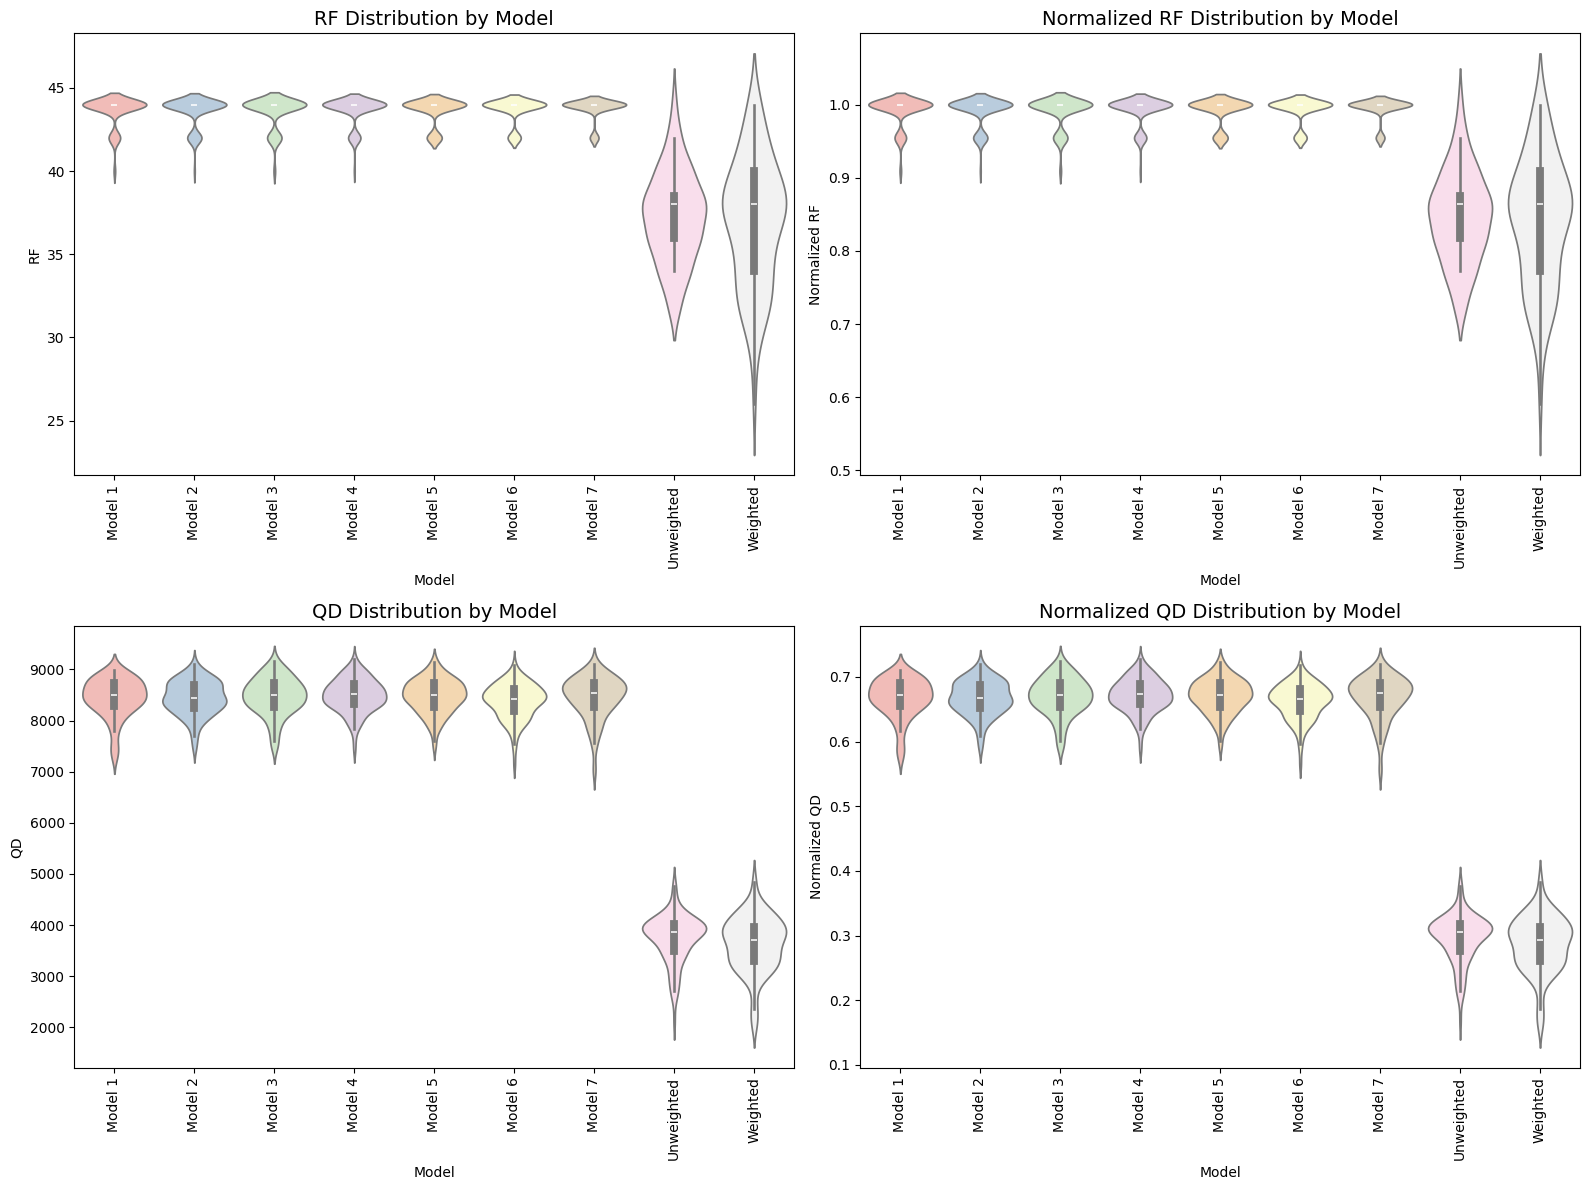

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 모델 이름
n_existing = len(models)
model_labels_all = [f"Model {i+1}" for i in range(n_existing)] + ["Unweighted", "Weighted"]

# long-form 데이터 생성 함수
def make_long_df(data_list, model_labels, metric_name):
    df = pd.DataFrame({
        "Value": [v for model in data_list for v in model],
        "Model": [model_labels[i] for i, model in enumerate(data_list) for _ in model]
    })
    df["Metric"] = metric_name
    return df

# long-form 데이터
df_rf = make_long_df(rf_distances_all, model_labels_all, "RF")
df_nrf = make_long_df(nrf_distances_all, model_labels_all, "Normalized RF")
df_qd = make_long_df(qds_all, model_labels_all, "QD")
df_nqd = make_long_df(nqds_all, model_labels_all, "Normalized QD")

df_all = pd.concat([df_rf, df_nrf, df_qd, df_nqd], ignore_index=True)

# -----------------------------
# 2x2 subplot 그리기
# -----------------------------
metrics = ["RF", "Normalized RF", "QD", "Normalized QD"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    df_plot = df_all[df_all["Metric"] == metric]
    sns.violinplot(
        x="Model",
        y="Value",
        data=df_plot,
        inner="box",
        palette="Pastel1",
        order=model_labels_all,
        ax=ax
    )
    ax.set_title(f"{metric} Distribution by Model", fontsize=14)
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()